<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Imports

In [1]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from seaborn import heatmap
from sklearn.utils import class_weight
from matplotlib import cm
from matplotlib.patches import Patch

from scipy.stats import randint

In [2]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 69.2MB 44kB/s 


In [3]:
# only run on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline

## Global parameters

In [5]:
# paths
PATH = '/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/'

# use gpu if possible
TASK = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# training iterations
ITERS = 1000

# random seed
SEED = 42

## Load data

In [6]:
data = np.load(f'{PATH}train.npz')['bands']
labels = np.load(f'{PATH}train.npz')['lulc']

test = np.load(f'{PATH}hidden_test.npz')['bands']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

## Preprocessing

In [7]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

## Exploratory Data Analysis?

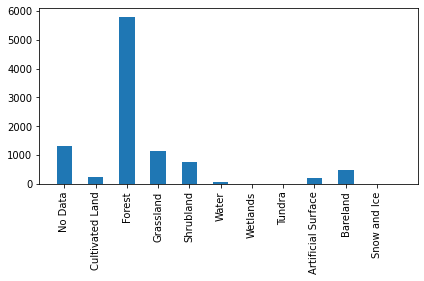

In [12]:
plt.hist(labels, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# Semi-Supervised Learning

## Training with only labelled data

In [8]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 72) (6953,), validation: (1739, 72) (1739,)'

In [9]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)
# fit on labelled data
cbm.fit(x_train, y_train)

In [10]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 99.22335682439235
F1-Score: [ 99.73614776  99.46351931  98.71292669  97.42310889 100.
  99.13043478 100.        ]
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       190
           2       0.99      1.00      0.99      4637
           3       0.99      0.98      0.99       900
           4       1.00      0.95      0.97       616
           5       1.00      1.00      1.00        46
           8       1.00      0.98      0.99       174
           9       1.00      1.00      1.00       390

    accuracy                           0.99      6953
   macro avg       1.00      0.99      0.99      6953
weighted avg       0.99      0.99      0.99      6953



Validation

Accuracy: 83.95629672225417
F1-Score: [65.93406593 92.91274068 68.23529412 41.66666667 66.66666667 63.76811594
 75.25773196]
              precision    recall  f1-score   support

           1       0.70      0.62      0.66        48
           2       0.

In [11]:
# fit the model on full labelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

## Predict labels for unlabelled data

In [12]:
# predict labels for unlabelled data
unlabelled_data_transformed = data[labels == 0, :, PIXEL_X, PIXEL_Y, :].reshape((data[labels == 0].shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(unlabelled_data_transformed).reshape(-1)

In [13]:
# train the model on labelled training instances and add predicted labels
x_train = np.concatenate((x_train, unlabelled_data_transformed))
y_train = np.concatenate((y_train, predicted_labels))
cbm.fit(x_train, y_train)

In [14]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 98.94685873380946
F1-Score: [ 99.74293059  99.3228388   98.30836153  96.08763693 100.
  97.63033175  99.88901221]
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       195
           2       0.99      1.00      0.99      5650
           3       0.99      0.97      0.98      1044
           4       1.00      0.93      0.96       663
           5       1.00      1.00      1.00        46
           8       0.99      0.97      0.98       213
           9       1.00      1.00      1.00       450

    accuracy                           0.99      8261
   macro avg       0.99      0.98      0.99      8261
weighted avg       0.99      0.99      0.99      8261



Validation

Accuracy: 83.84128809660724
F1-Score: [59.09090909 92.79279279 67.61229314 44.89795918 66.66666667 63.88888889
 75.78947368]
              precision    recall  f1-score   support

           1       0.65      0.54      0.59        48
           2       0.

## Hyperparameter Tuning:

In [20]:
# Get default params:
print(cbm.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 10, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 2, 3, 4, 5, 8, 9], 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.10000000149011612, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_ite

In [21]:
# Creating the hyperparameter grid
# Based on Docs: https://catboost.ai/docs/concepts/python-reference_catboost_randomized_search.html

param_dist = {"learning_rate": np.linspace(0,0.2,5),
              "depth": randint(3, 10),
              "l2_leaf_reg":[1, 3, 5, 7],}

In [22]:
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbm , param_dist, scoring='accuracy', cv=4, n_iter=ITERS, n_jobs=-1)

In [23]:
#Fit the model
rscv.fit(x_train, y_train)

RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fd036b8b810>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd035af2a90>,
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [24]:
# Best model:
best_model = rscv.best_estimator_

# Best accuracy:
best_accuracy = rscv.best_score_
print("\n The best accuracy score across ALL searched params:\n",rscv.best_score_)

# Best params:
best_params = rscv.best_params_
print("\n The best parameters across ALL searched params:\n",rscv.best_params_)


 The best accuracy score across ALL searched params:
 0.7942161690836769

 The best parameters across ALL searched params:
 {'depth': 9, 'l2_leaf_reg': 5, 'learning_rate': 0.2}


## Full fit with only labelled data

In [15]:
# final step: fit the model on all labelled data
labelled_data_transformed = data[labels != 0, :, PIXEL_X, PIXEL_Y, :].reshape((data[labels != 0].shape[0], data.shape[1] * data.shape[-1]))
labelled_data_labels = labels[labels != 0]
cbm.fit(labelled_data_transformed, labelled_data_labels)

## Full prediction of labels

In [16]:
# predict labels for unlabelled data
unlabelled_data_transformed = data[labels == 0, :, PIXEL_X, PIXEL_Y, :].reshape((data[labels == 0].shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(unlabelled_data_transformed).reshape(-1)

# overwrite existing labels without label
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

## Fit final model on full data

In [17]:
# fit model with full data
full_data_transformed = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
cbm.fit(full_data_transformed, new_labels)

# Results

## Metrics

## Visualization

In [18]:
test_transformed = []
for i in range(1500):
  for j in range(1500):
    pixel = test[:, i, j, :].reshape((72,))
    test_transformed.append(pixel)

test_transformed = np.array(test_transformed)

pred = cbm.predict(test_transformed).reshape((1500, 1500))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


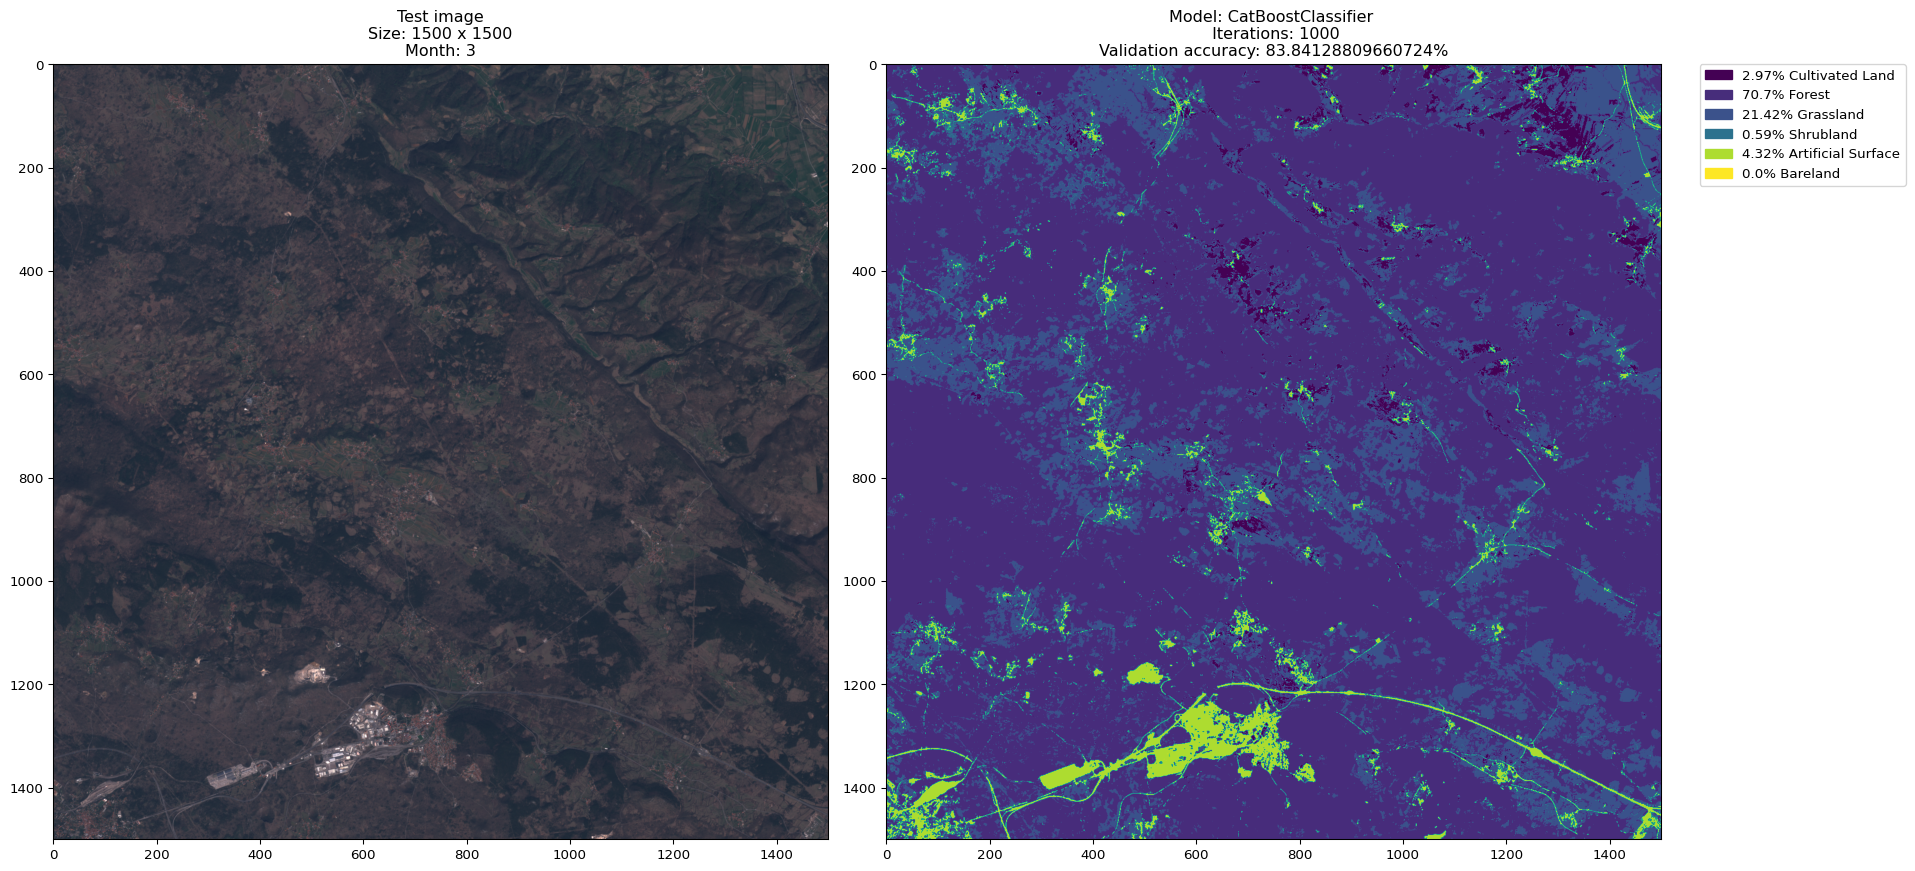

In [19]:
# plot image and predicted labels
month = 3

f, (sat, lulc) = plt.subplots(1, 2, figsize=(20,10), dpi=96, tight_layout=True)

band = 0.5 + 2.5 * (np.flip(test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')
sat.set_title(f'Test image\nSize: 1500 x 1500\nMonth: {month}')

im = lulc.imshow(pred)
colors = [im.cmap(im.norm(value)) for value in np.unique(pred).astype(int)]
portions = np.array([round(x, 2) for x in np.histogram(pred, bins=range(len(classes)))[0] / pred.shape[0] ** 2 * 100])[np.unique(pred).astype(int)]
patches = [Patch(color=colors[i], label=f'{portions[i]}% {classes[np.unique(pred).astype(int)[i]]}') for i in range(len(np.unique(pred).astype(int)))]

lulc.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
lulc.set_title(f'Model: CatBoostClassifier \n Iterations: {ITERS}\nValidation accuracy: {accuracy_score(y_val, cbm_val)*100}%')

plt.show()

## Export

In [30]:
# save plot, model and predictions
f.savefig(f'{PATH}plot.png')
np.save(f'{PATH}predictions.npy', pred)
cbm.save_model(f'{PATH}model')